## Notebook to plot the results of the fitting routine tests vs the same results for WFC3

In [1]:
import matplotlib.pyplot as plt
import pickle, bz2
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

%matplotlib notebook

#### Setup cell

In [2]:
dirsave = '/user/gennaro/Functional_work/Up_the_ramp_myfork/Simulations_results/'
testname = 'BKG_0p5_pow1'

In [3]:
outputs_file = dirsave+'Test_'+testname+'_out.pbz2'
inputs_file  = dirsave+'Test_'+testname+'_in.pbz2'
calwf3out_file = dirsave+'Test_'+testname+'_in.JSON'

#### Restore the saved files and prepare all variables

In [4]:
with bz2.BZ2File(outputs_file, 'rb') as f:
    dictoload = pickle.load(f)

goodints_l        =  dictoload['goodints_l']
counter_l         =  dictoload['counter_l']
error_l           =  dictoload['error_l']
crloops_counter_l =  dictoload['crloops_counter_l']
outerate_l        =  dictoload['outerate_l']
gof_stat_l        =  dictoload['gof_stat_l']
gof_pval_l        =  dictoload['gof_pval_l']


with bz2.BZ2File(inputs_file, 'rb') as f:
    dictoload = pickle.load(f)

meas_l     = dictoload['meas_l']
myfluxes   = dictoload['myfluxes']
myramps    = dictoload['myramps']
myCRrates  = dictoload['myCRrates']
mybgs      = dictoload['mybgs']
CRdict_l   = dictoload['CRdict_l']
extra_bg_l = dictoload['extra_bg_l']

del(dictoload)

#Unpack the lists to regroup items by ramp

ntest = len(meas_l)//len(myramps)

gi_list  = [np.empty([ntest,mm.group_times.size-1],dtype=np.bool_) for mm in myramps]
CR_list   = [[[] for _ in range(ntest)] for mm in myramps]
meas_list = [[[] for _ in range(ntest)] for mm in myramps]
ebg_list  = [[[] for _ in range(ntest)] for mm in myramps]

counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
error    = np.empty([ntest,len(myfluxes)],dtype=np.int_)
outerate = np.empty([ntest,len(myfluxes)])
crloops_counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
gof_stat = np.empty([ntest,len(myfluxes)])
gof_pval = np.empty([ntest,len(myfluxes)])

for l,(g,C,m,c,e,cc,o,gs,gp,eb) in enumerate(zip(goodints_l,CRdict_l,meas_l,counter_l,error_l,crloops_counter_l,outerate_l,gof_stat_l,gof_pval_l,extra_bg_l)):

    k = l % ntest
    j = l // ntest
    
    counter[k,j]  = c
    error[k,j]    = e
    crloops_counter[k,j] = cc
    outerate[k,j] = o
    gof_stat[k,j] = gs
    gof_pval[k,j] = gp

    gi_list[j][k,:] = g
    CR_list[j][k]   = C
    meas_list[j][k] = m
    ebg_list[j][k]  = eb
    


#### Restore calwf3 results

In [5]:
#Note, we put the df in a list to conform with the multiple-ramps mode for the non-calwf3 experiments

calwf3df = [pd.read_json(calwf3out_file)]
calwf3df[0].head()

,FLT_ERR_VALUE,FLT_PIXEL_VALUE,TRUTH_VALUE
0,0.032191,1.049862,"[True, True, True, True, True, True, True, Tru..."
1,0.031386,0.985125,"[True, True, True, True, True, True, True, Tru..."
2,0.032245,1.017947,"[True, True, True, True, True, True, True, Tru..."
3,0.031838,0.992728,"[True, True, True, True, True, True, True, Tru..."
4,0.031849,0.989940,"[True, True, True, True, True, True, True, Tru..."


#### Regroup all the simulated CRhits and check whether they have been detected

In [6]:
allCRtimes = []
allCRcounts = []
allCRdetect = []
allCRdetect_C3 = []

ramps_with_CRs = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):

    allCRtimes_p = []
    allCRcounts_p = []
    allCRdetect_p = []
    allCRdetect_C3_p = []
    ramps_with_CRs_p = np.zeros(len(CR_list[j]),dtype=np.bool_)
    
    CRlist_p = CR_list[j]
    for i,dd in enumerate(CRlist_p):
        if dd is not None:
            ramps_with_CRs_p[i] = True
            allCRtimes_p.extend(dd['times'])
            allCRcounts_p.extend(dd['counts'])
            for t in dd['times']:
                hit_intv_idx = np.nonzero(myramp.group_times <= t)[0][-1]
                if gi_list[j][i,hit_intv_idx] ==  False:
                    allCRdetect_p.append(True)
                else:
                    allCRdetect_p.append(False)

                if calwf3df[j].loc[i,'TRUTH_VALUE'][hit_intv_idx] ==  False:
                    allCRdetect_C3_p.append(True)
                else:
                    allCRdetect_C3_p.append(False)

                    
            
    
    #print(allCRcounts_p)
    #print(allCRtimes_p)
    allCRtimes.append(np.asarray(allCRtimes_p))
    allCRcounts.append(np.asarray(allCRcounts_p))
    allCRdetect.append(np.asarray(allCRdetect_p))
    allCRdetect_C3.append(np.asarray(allCRdetect_C3_p))
    
    ramps_with_CRs.append(ramps_with_CRs_p)


#### Look for false positives in the detected CRhits

In [7]:
CR_false_positives = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    CR_false_positives_p = np.zeros_like(gi_list[j],dtype=np.bool_)
    print('*************')
    print(myflux,myramp.ngroups)
    for i in range(ntest):
        detected_CR_idx = np.nonzero(~gi_list[j][i,:])[0]
        ndet = len(detected_CR_idx)
        if ndet > 0:
            CRdict  = CR_list[j][i]
            for k in range(ndet):
                if CRdict is None:
                    CR_false_positives_p[i,detected_CR_idx[k]] = True
                else:   
                    ts = myramp.group_times[detected_CR_idx[k]]
                    te = myramp.group_times[detected_CR_idx[k]+1]
                    if np.all( (CRdict['times']< ts) | ((CRdict['times']> te))) == True:
                        CR_false_positives_p[i,detected_CR_idx[k]] = True
                    
    print(np.sum(CR_false_positives_p))       
    CR_false_positives.append(CR_false_positives_p)
    

*************
0.5 15
82


### Diagnostic plots

#### Global diagnostics

In [8]:
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

MD rng: [0.97733136 1.01909313]


<IPython.core.display.Javascript object>


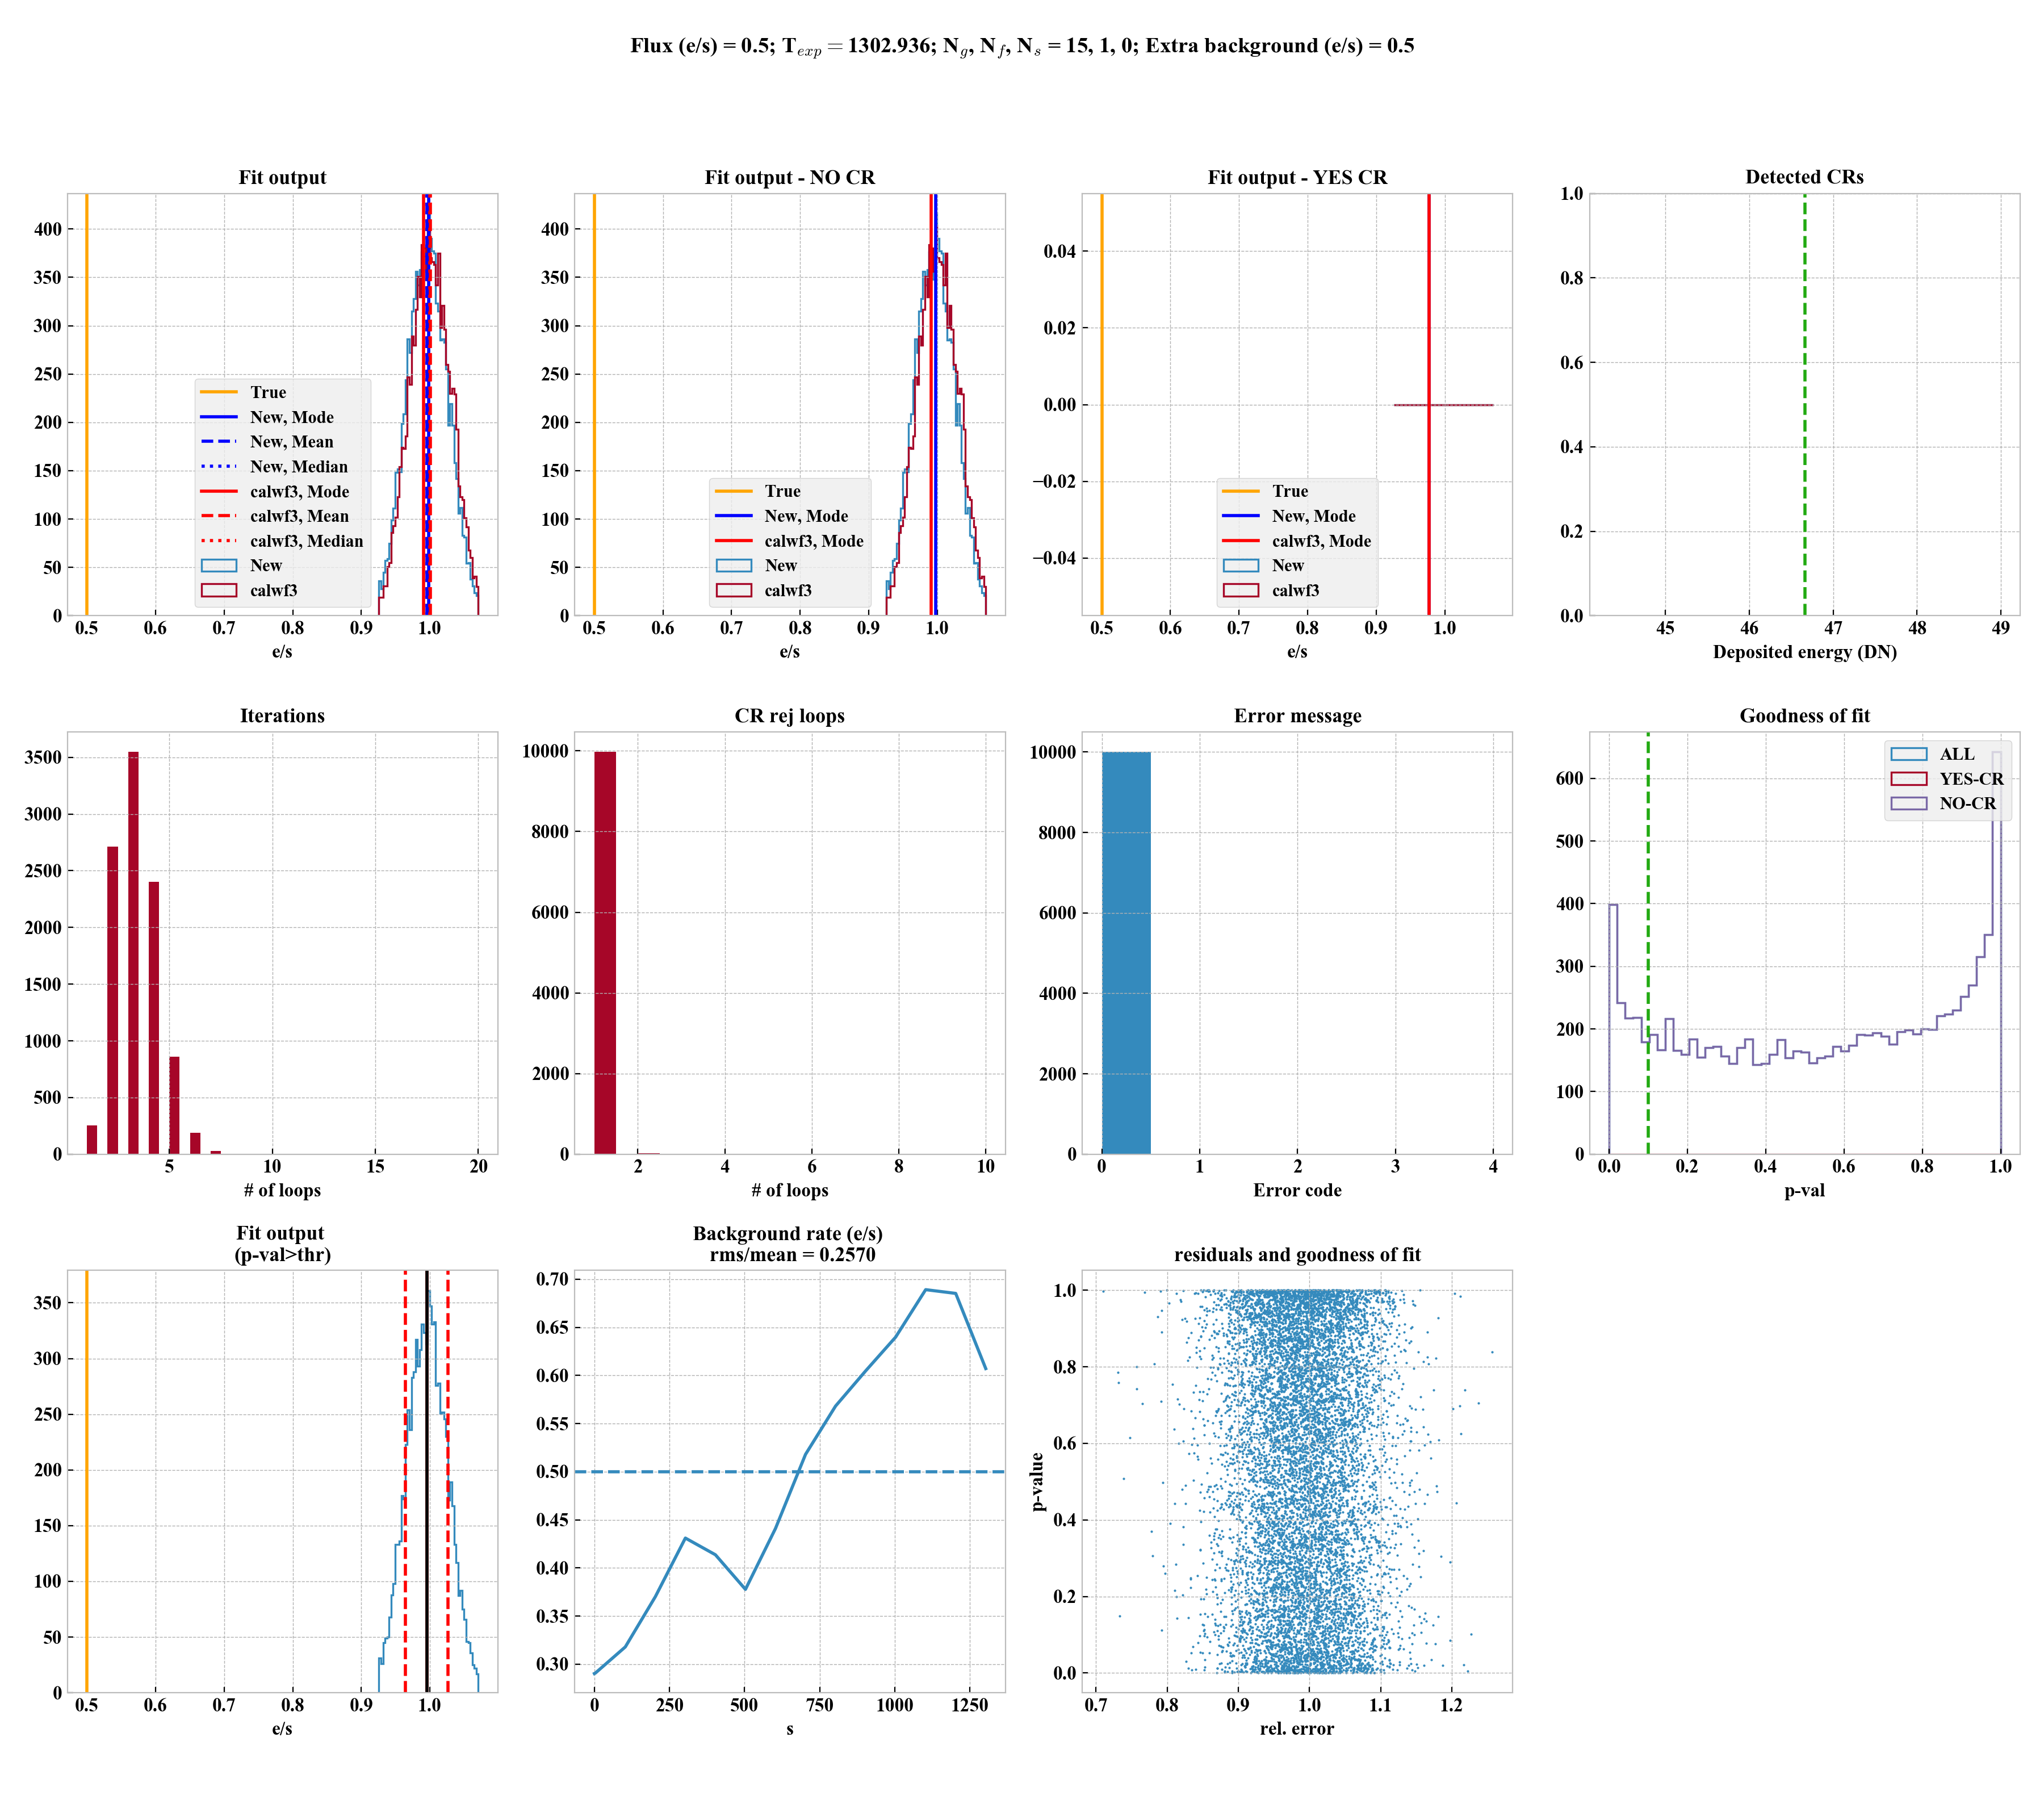

H range:  0.9257426649710133 1.070646159377361


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/

######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 10000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0276
 
Output mean (e/s):  0.9958 [new] /  1.0005 [calwf3]
Output median (e/s):  0.9959 [new] /  1.0000 [calwf3]
Output mode (e/s):  0.9980 [new] /  0.9909 [calwf3]
Output standard deviation (e/s):  0.0310 [new] /  0.0307 [calwf3]
Rel. % error: :  6.20 [new] /  6.15 [calwf3]
Rel. % bias:: 99.16 [new] / 100.10 [calwf3]
 
no-CR Output mean (e/s):  0.9958 [new] /  1.0005 [calwf3]
no-CR Output median (e/s):  0.9959 [new] /  1.0000 [calwf3]
no-CR Output mode (e/s):  0.9980 [new] /  0.9909 [calwf3]
no-CR Output standard deviation (e/s):  0.031

In [10]:
lw=1.2

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    
    BM0 = (error[:,j] == 0) #& (counter[:,j] > 15)
    mn = np.mean(outerate[BM0,j])
    md = np.median(outerate[BM0,j])
    st = np.std(outerate[BM0,j])

    C3_out = calwf3df[j]['FLT_PIXEL_VALUE'].values
    mn_C3 = np.mean(C3_out)
    md_C3 = np.median(C3_out)
    st_C3 = np.std(C3_out)

    vall = np.hstack([outerate[BM0,j],C3_out])
    
    mode_rng = np.percentile(vall, (25, 75))
    print('MD rng:',mode_rng)
    mode_bins=100
    
    f = plt.figure(figsize=(18,16))
    
#    minbin = md_C3-3*st_C3#np.min(np.hstack([outerate[BM0,j],C3_out]))
#    maxbin = md_C3+4*st_C3#np.max(np.hstack([outerate[BM0,j],C3_out]))
    minbin,maxbin = np.percentile(vall, (1,99))
    print('H range: ',minbin,maxbin)
    
    nbh = 50
    
    ax1 = f.add_subplot(3,4,1)
    n,b,p = ax1.hist(outerate[BM0,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='New',linewidth=lw)
    ax1.hist(C3_out,bins=b,histtype='step',label='calwf3',linewidth=lw)

    h,b = np.histogram(outerate[BM0,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out, bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode_C3 = 0.5*(b[imode]+b[imode+1])
    
    ax1.axvline(myflux,color='orange',label='True')
    ax1.axvline(mode,color='b',label='New, Mode')
    ax1.axvline(mn,color='b',label='New, Mean',linestyle='--')
    ax1.axvline(md,color='b',label='New, Median',linestyle=':')
#    ax1.axvline(mn-st,color='b',linestyle='--')
#    ax1.axvline(mn+st,color='b',linestyle='--')
    ax1.axvline(mode_C3,color='r',label='calwf3, Mode')
    ax1.axvline(mn_C3,color='r',label='calwf3, Mean',linestyle='--')
    ax1.axvline(md_C3,color='r',label='calwf3, Median',linestyle=':')
#    ax1.axvline(mn_C3-st_C3,color='r',linestyle='--')
#    ax1.axvline(mn_C3+st_C3,color='r',linestyle='--')
    #ax1.axvline(md,color='black',label='New, Median')
    
    
    ax1.set_title('Fit output',fontsize=13)
    ax1.set_xlabel('e/s')
    ax1.legend()

    ######################################################
    
    rCRs = ramps_with_CRs[j]
    BM2 = BM0 & (~rCRs)
    mn2 = np.mean(outerate[BM2,j])
    md2 = np.median(outerate[BM2,j])
    st2 = np.std(outerate[BM2,j])
    
    mn2_C3 = np.mean(C3_out[~rCRs])
    md2_C3 = np.median(C3_out[~rCRs])
    st2_C3 = np.std(C3_out[~rCRs])

    h,b = np.histogram(outerate[BM2,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode2 = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out[~rCRs], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode2_C3 = 0.5*(b[imode]+b[imode+1])

    
    ax2 = f.add_subplot(3,4,2)
    n,b,p = ax2.hist(outerate[BM2,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='New',linewidth=lw)
    ax2.hist(C3_out[~rCRs],bins=b,histtype='step',label='calwf3',linewidth=lw)

    ax2.axvline(myflux,color='orange',label='True')
    ax2.axvline(mode2,color='b',label='New, Mode')
#    ax2.axvline(mn2-st2,color='b',linestyle='--')
#    ax2.axvline(mn2+st2,color='b',linestyle='--')
    ax2.axvline(mode2_C3,color='r',label='calwf3, Mode')
#    ax2.axvline(mn2_C3-st2_C3,color='r',linestyle='--')
#    ax2.axvline(mn2_C3+st2_C3,color='r',linestyle='--')
    #ax1.axvline(md,color='black',label='New, Median')
    
    
    ax2.set_title('Fit output - NO CR',fontsize=13)
    ax2.set_xlabel('e/s')
    ax2.legend()

      ######################################################
   
    BM3 = BM0 & rCRs
    mn3 = np.mean(outerate[BM3,j])
    md3 = np.median(outerate[BM3,j])
    st3 = np.std(outerate[BM3,j])

    mn3_C3 = np.mean(C3_out[rCRs])
    md3_C3 = np.median(C3_out[rCRs])
    st3_C3 = np.std(C3_out[rCRs])

    h,b = np.histogram(outerate[BM3,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode3 = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out[rCRs], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode3_C3 = 0.5*(b[imode]+b[imode+1])


    h,b = np.histogram(outerate[BM0,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out, bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode_C3 = 0.5*(b[imode]+b[imode+1])

    ax3 = f.add_subplot(3,4,3)
    n,b,p = ax3.hist(outerate[BM3,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='New',linewidth=lw)
    ax3.hist(C3_out[rCRs],bins=b,histtype='step',label='calwf3',linewidth=lw)

    ax3.axvline(myflux,color='orange',label='True')
    ax3.axvline(mode3,color='b',label='New, Mode')
#    ax3.axvline(mn3-st3,color='b',linestyle='--')
#    ax3.axvline(mn3+st3,color='b',linestyle='--')
    ax3.axvline(mode3_C3,color='r',label='calwf3, Mode')
#    ax3.axvline(mn3_C3-st3_C3,color='r',linestyle='--')
#    ax3.axvline(mn3_C3+st3_C3,color='r',linestyle='--')
    #ax1.axvline(md,color='black',label='New, Median')
    
    
    ax3.set_title('Fit output - YES CR',fontsize=13)
    ax3.set_xlabel('e/s')
    ax3.legend()
    
    
    ######################################################
    ax4 = f.add_subplot(3,4,4)
    if allCRcounts[j].size >0 :
        b=np.linspace(0,1001,50)
        if allCRdetect[j].size >0 :
            n,b,p = ax4.hist(allCRcounts[j][allCRdetect[j]],bins=b,histtype='step',label='New',linewidth=lw)
        if allCRdetect_C3[j].size >0 :
            n,b,p = ax4.hist(allCRcounts[j][allCRdetect_C3[j]],bins=b,histtype='step',label='calwf3',linewidth=lw)
        n,b,p = ax4.hist(allCRcounts[j],bins=b,histtype='step',label='ALL',linewidth=lw)
    
    ax4.axvline(4*np.sqrt(myflux*np.mean(myramp.group_times[1:]-myramp.group_times[:-1])+2*np.square(meas_list[j][0].RON_adu)),color='#22aa12',linestyle='--')
    ax4.set_title('Detected CRs',fontsize=13)
    ax4.set_xlabel('Deposited energy (DN)')
    ax4.legend(loc=4)
    ######################################################
   
    
    ax5 = f.add_subplot(3,4,5)
    n,b,p = ax5.hist(counter[:,j],bins=np.linspace(1,20,39))
    n,b,p = ax5.hist(counter[BM0,j],bins=b)
    ax5.set_title('Iterations',fontsize=13)
    ax5.set_xlabel('# of loops')

    ######################################################
   
    ax6 = f.add_subplot(3,4,6)
    n,b,p = ax6.hist(crloops_counter[:,j],bins=np.linspace(1,10,19))
    n,b,p = ax6.hist(crloops_counter[BM0,j],bins=b)
    ax6.set_title('CR rej loops',fontsize=13)
    ax6.set_xlabel('# of loops')
    ######################################################

    ax7 = f.add_subplot(3,4,7)
    n,b,p = ax7.hist(error[:,j],bins=np.linspace(0,4,9))
    ax7.set_title('Error message',fontsize=13) 
    ax7.set_xlabel('Error code')
    ######################################################

    ax8 = f.add_subplot(3,4,8)   
    pthr = 0.1
    b = np.linspace(0,1,50)
    n,b,p = ax8.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j])],bins=b,linewidth=lw,histtype='step',label='ALL')
    n,b,p = ax8.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j]) & rCRs],bins=b,linewidth=lw,histtype='step',label='YES-CR')
    n,b,p = ax8.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j]) & (~rCRs)],bins=b,linewidth=lw,histtype='step',label='NO-CR')
#    n,b,p = ax8.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j]) & (np.asarray([kk is not None for kk in CR_list[j]]))],bins=np.linspace(0,1,50),linewidth=lw,histtype='step',label='YES-CR')
#    n,b,p = ax6.hist(gof_stat[:,j]/(np.sum(gi_list[j],axis=1)-1),bins=np.linspace(0,3,50))
#    n,b,p = ax6.hist(gof_stat[:,j],bins=50)
#    ax6.scatter(gof_pval[:,j],gof_stat[:,j])
    
    ax8.set_title('Goodness of fit',fontsize=13)
    ax8.axvline(pthr,color='#22aa12',linestyle='--')
    ax8.set_xlabel('p-val')
#    ax8.set_xscale('log')
    ax8.legend()
    
    BMpt = gof_pval[:,j] > pthr
    
    ######################################################
    BM1 = BM0 & BMpt
    mn1 = np.mean(outerate[BM1,j])
    md1 = np.median(outerate[BM1,j])
    st1 = np.std(outerate[BM1,j])

    
    ax9 = f.add_subplot(3,4,9)
    ax9.hist(outerate[BM1,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',linewidth=lw)
    ax9.axvline(myflux,color='orange')
    ax9.axvline(mn1,color='red')
    ax9.axvline(mn1-st1,color='red',linestyle='--')
    ax9.axvline(mn1+st1,color='red',linestyle='--')
    ax9.axvline(md1,color='black')
    ax9.set_title('Fit output \n(p-val>thr)',fontsize=13)
    ax9.set_xlabel('e/s')
    ######################################################

    ax10 = f.add_subplot(3,4,10)

    if mybgs[j] is not None:
        mean_bg_electron_rate = mybgs[j]['mean_bg_er']
        bg_times = mybgs[j]['times']
        bg_electron_rate = mybgs[j]['vbg_er']

        bg_int = interp1d(bg_times,bg_electron_rate,'quadratic')
        varbg = bg_int(myramps[j].read_times)

        dt = myramp.read_times[-1]-myramp.read_times[0]
        t_avg = np.trapz(varbg,myramps[j].read_times) / dt
        varbg = varbg/t_avg * mean_bg_electron_rate
        a_rms = np.sqrt(np.trapz(np.square(varbg-mean_bg_electron_rate),myramps[j].read_times)/dt)

        ax10.set_title('Background rate (e/s) \n rms/mean ={:7.4f}'.format(a_rms/mean_bg_electron_rate),fontsize=13)
        ax10.set_xlabel('s')
        ax10.plot(myramp.read_times,varbg);
        ax10.axhline(mean_bg_electron_rate,linestyle='--')
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{g}}$, N$_{{f}}$, N$_{{s}}$ = {}, {}, {}; Extra background (e/s) = {}'.format(myflux,myramp.group_times[-1],myramp.ngroups,myramp.nframes,myramp.nskips,mean_bg_electron_rate)
    else:
        ax10.set_title('No extra background',fontsize=13)
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{g}}$, N$_{{f}}$, N$_{{s}}$ = {}, {}, {}; No extra background'.format(myflux,myramp.group_times[-1],myramp.ngroups,myramp.nframes,myramp.nskips)
        
    ######################################################
    
    
    ax11 = f.add_subplot(3,4,11)
    ax11.scatter((outerate[:,j]-myflux)/myflux,gof_pval[:,j],s=1)
    ax11.set_xlabel('rel. error')
    ax11.set_ylabel('p-value')
    ax11.set_title('residuals and goodness of fit',fontsize=13)
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]:
        ax.set_axis_bgcolor('#FFFFFF')

        
    
    
    f.suptitle(sts, fontsize=14)
    f.tight_layout(rect=[0,0.03,1,.92])

    
    actual_counts = np.empty(len(meas_list[j]))
    for k in range(actual_counts.size):
        actual_counts[k] = meas_list[j][k].noiseless_counts[-1]
    
    
    exptime = myramp.group_times[-1] - myramp.group_times[0] 
    mean_signal = myflux * exptime
    poi_err = np.sqrt(mean_signal)
    act_poi_err = np.std(actual_counts)*meas_list[j][0].gain
    
    eff_RON = meas_list[j][0].effRON_e
    eff_qerr = np.sqrt(meas_list[j][0].gain*myramp.nframes/12) * eff_RON/meas_list[j][0].RON_e

    tot_noise = np.sqrt(np.sum(np.square(np.array([poi_err,eff_RON,eff_qerr]))))


    
    print('######################')
    print('Input flux (e/s):',myflux)
    print('Exposure time',exptime)
    print('Number of groups / frames / skips: {} / {} / {}'.format(myramp.ngroups,myramp.nframes,myramp.nskips))
    print('Number of tests:',ntest)
    print('Fraction of good fits:',100.*BM0.sum().astype(np.float_)/ntest,'%')
    print(' ')    
    print('Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: {:6.3f}, {:6.3f}, {:6.3f}, {:6.3}'.format(
        100.*poi_err/mean_signal, 100.*eff_RON/mean_signal, 100.*eff_qerr/mean_signal, 100*tot_noise/mean_signal))
    print('Pure Poisson / eff. RON / eff. quantization error / total error [e/s]: {:7.4f}, {:7.4f}, {:7.4f}, {:7.4f}'.format(
        poi_err/exptime, eff_RON/exptime, eff_qerr/exptime, tot_noise/exptime))
    print('Standard deviation from "noiseless" counts (e/s): {:7.4f}'.format(act_poi_err/exptime))
    print(' ')
    print('Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn,mn_C3))
    print('Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md,md_C3))
    print('Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode,mode_C3))
    print('Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st,st_C3))
    print('Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st/myflux,100.*st_C3/myflux))
    print('Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn-myflux)/myflux,100*(mn_C3-myflux)/myflux))
    print(' ')
    print('no-CR Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn2,mn2_C3))
    print('no-CR Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md2,md2_C3))
    print('no-CR Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode2,mode2_C3))
    print('no-CR Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st2,st2_C3))
    print('no-CR Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st2/myflux,100.*st2_C3/myflux))
    print('no-CR Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn2-myflux)/myflux,100*(mn2_C3-myflux)/myflux))
    print(' ')
    print('yes-CR Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn3,mn3_C3))
    print('yes-CR Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md3,md3_C3))
    print('yes-CR Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode3,mode3_C3))
    print('yes-CR Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st3,st3_C3))
    print('yes-CR Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st3/myflux,100.*st3_C3/myflux))
    print('yes-CR Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn3-myflux)/myflux,100*(mn3_C3-myflux)/myflux))
    print(' ')
    print('Fraction of good fits at {:6.3f} confidence: {} %'.format(pthr,100.*np.sum(BMpt)/len(BMpt)))
    print('p-flagged Output mean (e/s) {:7.4f}'.format(mn1))
    print('p-flagged Output median (e/s) {:7.4f}'.format(md1))
    print('p-flagged Output standard deviation (e/s) {:7.4f}'.format(st1))
    print('p-flagged Rel. % error: {:5.2f}'.format(100.*st1/myflux))
    print('p-flagged Rel. % bias: {:5.2f}'.format(100.*(mn1-myflux)/myflux))
    print(' ')
    print('CR hits / detected',len(allCRcounts[j]),'/',np.sum(allCRdetect[j]))
    print('CR - false positives',np.sum(CR_false_positives[j]))
    

#### Detailed plots to examine the false positive cases

#### Detailed plots to examine the bad fit (ERR > 0) cases